In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from joblib import dump, load

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
df.shape

(892, 18)

In [2]:
df = pd.read_csv('../../data/processed/WESAD/data_processed/30s/addon_feature_data.csv', index_col=0)
df.head(10)

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,EDA_slope_clipped,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,hrv_composite,hrv_stress_index,arousal_index
0,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,...,-0.000265,-0.000265,0,34.746298,0.005886,1415.545722,-0.035662,96.253149,0.595642,741.047339
1,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,...,0.000048,0.000048,1,40.870200,0.013768,1742.228749,0.007070,124.282730,0.976977,906.047629
2,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,...,-0.000203,-0.000203,0,32.095491,0.004064,1562.857969,-1.403354,132.380562,0.676597,770.658757
3,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,...,-0.000283,-0.000283,0,30.942103,0.007608,1375.012643,0.164330,98.535106,0.650496,646.969837
4,46.228000,-39.174667,13.782000,62.674127,1.910619,0.442887,0.007276,-0.000196,22.165715,1.926374,...,-0.000196,-0.000196,0,33.749942,0.003777,1689.123832,-0.076409,116.329704,1.112837,748.091592
5,54.778667,-4.560667,23.690000,63.209987,3.433404,0.420447,0.006317,-0.000177,23.576240,1.535128,...,-0.000177,-0.000177,0,29.186010,0.004115,1636.582156,-0.797444,59.254808,0.633857,688.096371
6,57.572667,2.945333,25.359333,63.168013,1.161933,0.400438,0.005144,-0.000141,16.950863,4.695297,...,-0.000141,-0.000141,0,27.686864,0.001095,1172.008372,1.518641,36.768739,0.800024,469.316229
7,56.001333,-0.588000,4.648000,63.107238,2.198306,0.387997,0.002526,-0.000036,18.162599,1.808051,...,-0.000036,-0.000036,0,30.031357,0.001397,1405.803666,0.116360,113.521618,0.897603,545.447476
8,43.666000,-44.600000,-4.816667,62.702483,0.451626,0.380663,0.006353,-0.000172,22.041985,1.488773,...,-0.000172,-0.000172,0,31.136398,0.004267,1802.930245,0.103158,163.489965,0.882565,686.308010
9,41.298000,-41.818000,9.714667,62.632574,3.089226,0.359758,0.004721,-0.000129,20.260492,1.489400,...,-0.000129,-0.000129,0,26.254490,0.003169,1478.576176,0.204442,139.244578,0.674967,531.928881


In [3]:
columns_drop = [col for col in df.columns if 'acc' in col.lower()]
df = df.drop(columns=columns_drop)

In [4]:
X = df.drop(columns=['subject', 'focus_label', 'label'])
y = df['focus_label']

In [5]:
selector = SelectKBest(score_func=f_classif, k=18)
X_selected = selector.fit_transform(X, y)
selected_columns = X.columns[selector.get_support()]

In [6]:
df = df[selected_columns]
df.head(10)

,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,hr_center,hr_zscore,resp_zscore,EDA_slope_clipped,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,arousal_index
0,0.523506,0.009367,-0.000265,21.327375,1.591487,66.372243,911.132812,-12.015288,-1.366112,0.026105,-0.000265,-0.000265,0,34.746298,0.005886,1415.545722,-0.035662,741.047339
1,0.520051,0.018623,0.000048,22.168906,1.352590,78.588847,803.631757,0.201316,0.022889,0.308898,0.000048,0.000048,1,40.870200,0.013768,1742.228749,0.007070,906.047629
2,0.493109,0.007353,-0.000203,24.011434,1.809602,65.088073,940.020161,-13.299458,-1.512120,0.928071,-0.000203,-0.000203,0,32.095491,0.004064,1562.857969,-1.403354,770.658757
3,0.470519,0.010338,-0.000283,20.909046,1.358827,65.761617,924.316406,-12.625914,-1.435539,-0.114473,-0.000283,-0.000283,0,30.942103,0.007608,1375.012643,0.164330,646.969837
4,0.442887,0.007276,-0.000196,22.165715,1.926374,76.204346,822.482639,-2.183185,-0.248223,0.307825,-0.000196,-0.000196,0,33.749942,0.003777,1689.123832,-0.076409,748.091592
5,0.420447,0.006317,-0.000177,23.576240,1.535128,69.416589,867.424242,-8.970942,-1.019977,0.781826,-0.000177,-0.000177,0,29.186010,0.004115,1636.582156,-0.797444,688.096371
6,0.400438,0.005144,-0.000141,16.950863,4.695297,69.141518,869.485294,-9.246013,-1.051252,-1.444603,-0.000141,-0.000141,0,27.686864,0.001095,1172.008372,1.518641,469.316229
7,0.387997,0.002526,-0.000036,18.162599,1.808051,77.401021,811.607143,-0.986510,-0.112164,-1.037404,-0.000036,-0.000036,0,30.031357,0.001397,1405.803666,0.116360,545.447476
8,0.380663,0.006353,-0.000172,22.041985,1.488773,81.795277,787.760417,3.407746,0.387453,0.266246,-0.000172,-0.000172,0,31.136398,0.004267,1802.930245,0.103158,686.308010
9,0.359758,0.004721,-0.000129,20.260492,1.489400,72.978296,844.642857,-5.409236,-0.615018,-0.332417,-0.000129,-0.000129,0,26.254490,0.003169,1478.576176,0.204442,531.928881


In [7]:
df.columns

Index(['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'hr_center', 'hr_zscore', 'resp_zscore',
       'EDA_slope_clipped', 'EDA_slope_log', 'EDA_slope_pos',
       'eda_hr_interaction', 'eda_resp_ratio', 'hr_resp_interaction',
       'hr_resp_z_interaction', 'arousal_index'],
      dtype='object')

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(max_depth=12, min_samples_split=2, n_estimators=200, random_state=42))
])

In [9]:
pipeline.fit(X_selected, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=12, n_estimators=200,
                                        random_state=42))])

In [13]:
X_scaled = pipeline.named_steps['scaler'].transform(X_selected)

In [14]:
explainer = shap.TreeExplainer(pipeline.named_steps['clf'], X_scaled)

In [15]:
shap_values = explainer(X_scaled)

 97%|=================== | 1722/1784 [00:25<00:00]       

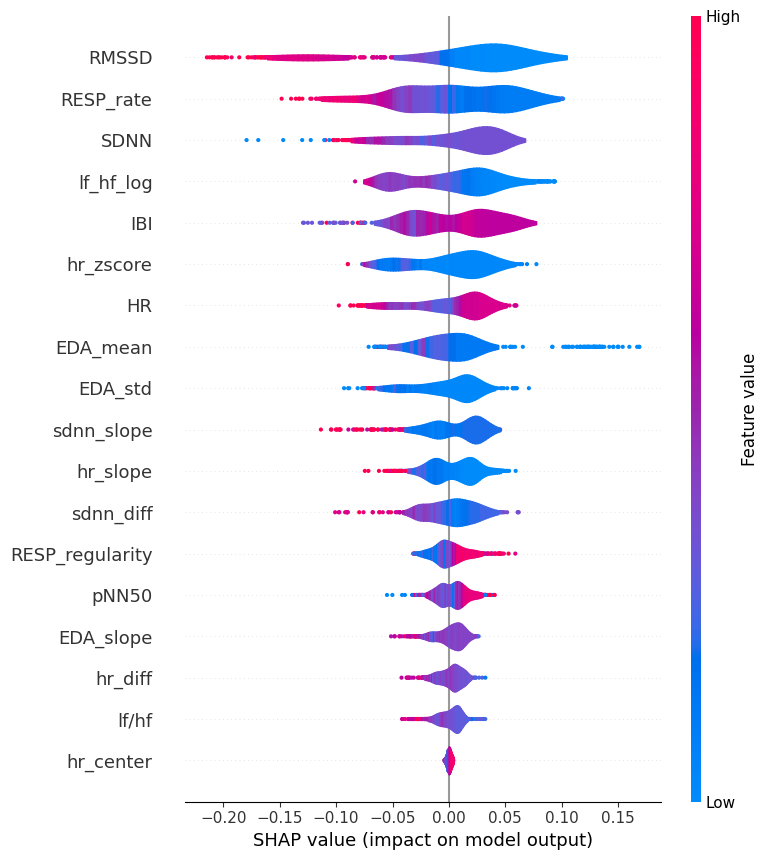

In [26]:
shap.summary_plot(
    shap_values[:, :, 1],
    plot_type='violin',
    feature_names=X.columns
)